In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [124]:
df = pd.read_csv("clean_data.csv")
df

,price,brand,ram,ram_type,display_size,display_type,pixels,screen_rate,screen_panel,length,...,hdd,ssd,OS,weight,cpu_rank,gpu_rank,cpu_point,gpu_point,fingerprint_reader,web_camera
0,3049.99,LENOVO,64.0,DDR5,15.6,QHD,3686400.0,165.0,IPS,358.80,...,0.0,2000.0,WINDOWS,2.40,17.0,35.0,15486.0,8841.0,1.0,0.0
1,1819.00,ACER,32.0,DDR5,15.6,FHD,2073600.0,144.0,IPS,360.40,...,0.0,2000.0,WINDOWS,2.50,17.0,34.0,15486.0,8864.0,1.0,0.0
2,2359.99,ACER,32.0,DDR4,16.0,WQXGA,4096000.0,165.0,IPS,358.14,...,0.0,1000.0,WINDOWS,2.44,37.0,39.0,12390.0,8290.0,1.0,0.0
3,1099.99,DELL,16.0,DDR4,14.0,FHD+,2304000.0,0.0,IPS,314.00,...,0.0,1000.0,WINDOWS,1.55,52.0,114.0,10523.0,1129.0,1.0,0.0
4,719.99,LENOVO,16.0,DDR4,15.6,FHD,2073600.0,0.0,IPS,359.20,...,0.0,1000.0,WINDOWS,1.70,99.0,107.0,5125.0,1435.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6602,817.99,HP,16.0,DDR4,15.6,FHD,2073600.0,0.0,IPS,358.90,...,0.0,1000.0,WINDOWS,1.70,78.0,121.0,7983.0,914.0,1.0,0.0
6603,844.57,ACER,8.0,LPDDR4X,14.0,FHD,2073600.0,0.0,IPS,320.04,...,0.0,512.0,WINDOWS,1.25,63.0,115.0,9469.0,1097.0,0.0,1.0
6604,3559.00,ASUS,64.0,DDR5,17.3,QHD,3686400.0,240.0,IPS,395.00,...,0.0,4000.0,WINDOWS,2.80,1.0,9.0,34357.0,11933.0,1.0,0.0
6605,1599.00,LG,16.0,LPDDR4X,16.0,WQXGA,4096000.0,0.0,IPS,356.60,...,0.0,1000.0,WINDOWS,1.50,99.0,107.0,5125.0,1435.0,1.0,0.0


In [125]:
df.brand.value_counts()

HP           2338
LENOVO       1305
ASUS          792
MSI           775
DELL          774
ACER          400
LG            165
AORUS          17
SAMSUNG         9
MICROSOFT       8
ALIENWARE       5
RAZER           5
PANASONIC       5
DYNABOOK        4
GIGABYTE        4
ENVY            1
Name: brand, dtype: int64

- ENVY brand just have one laptop so we remove it from the dataset.

In [126]:
df = df.drop(df[df.brand == 'ENVY'].index)

## Split train, test data

In [164]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, stratify=df['brand'], test_size=0.05, random_state=2023)

In [165]:
X_train = train_set.drop('price', axis=1)
y_train = train_set['price'].copy()

X_test = test_set.drop('price', axis=1)
y_test = test_set['price'].copy()

## Prepare data for training:

In [166]:
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# make a pipeline for number column
num_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    StandardScaler())

# make a pipeline for categorical column
cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown='ignore'))

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
     (cat_pipeline, make_column_selector(dtype_include=object))
)

## Define linear model:

In [188]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
import math
import seaborn as sns

class ModelLinearRegression:
    """
    Class Model:
    Linear Regression's docs (using sklearn): https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
    ---------------------
    Properties:
        model_pipeline: contain preprocessing pipeline + model.
        y_pred: list(float)
            Predicted values.
        score_mae: float 
            Mean absolute error score computed from y_pred and y_test (ground truth).
        score_rmse: float
            Root mean square error score computed from y_pred and y_test (ground truth).
        score_mape: float
            Mean absolute percentage error score computed from y_pred and y_test (ground truth).
    ---------------------
    Methods:
        __init__(self, preprocessing_pipeline):
            Initialize the model pipeline.
        
        train(self, X_train, y_train):
            Train the model using train dataset.
        
        predict(self, X_test):
            Predict the values using data in X_test.
        
        evaluate(self, y_true, y_pred):
            Evaluate the predict result by computing 3 metrics scores (MAE, RMSE, MAPE)
        
        plot_result(self, width, height, X_test, y_test):
            Visualize the result including predict values (blue), ground truth (yellow).
            
        plot_yy(self, width, height, x_test, y_test):
            Visualize the predicted values & ground truth.
    """
    def __init__(self, preprocessing_pipeline):
        self.preprocessing_pipeline = preprocessing_pipeline
        self.model_pipeline = make_pipeline(self.preprocessing_pipeline, LinearRegression())
    
    def train(self, X_train, y_train):
        self.model_pipeline.fit(X_train, y_train)
        
    def predict(self, X_test):
        self.y_pred = self.model_pipeline.predict(X_test)
        return self.y_pred
    
    def evaluate(self, y_true, y_pred):
        self.score_mae = mean_absolute_error(y_true, y_pred)
        self.score_rmse = math.sqrt(mean_squared_error(y_true, y_pred))
        self.score_mape = mean_absolute_percentage_error(y_true, y_pred)
        
        print('MAE: {}'.format(self.score_mae))
        print('RMSE: {}'.format(self.score_rmse))
        print('MAPE: {}'.format(self.score_mape))
        
        return self.score_mae, self.score_rmse, self.score_mape
    
    def plot_result(self, width, height, X_test, y_test):
        f, ax = plt.subplots(1)
        f.set_figheight(height)
        f.set_figwidth(width)

        sns.lineplot(x=np.arange(0, X_test[:, 0].shape[0]), y=self.y_pred, ax=ax, color='blue', label='Predict')
        sns.lineplot(x=np.arange(0, X_test[:, 0].shape[0]), y=y_test, ax=ax, color='orange', label='Ground truth') 

        ax.set_title(f'Prediction \n MAE: {self.score_mae:.2f}, RMSE: {self.score_rmse:.2f}, MAPE: {self.score_mape:.2f}', fontsize=14)
        ax.set_xlabel(xlabel='Sample', fontsize=14)
        ax.set_ylabel(ylabel='Price', fontsize=14)
        plt.show()

    def plot_yy(self, width, height, y_pred, y_test):
        f, ax = plt.subplots(1)
        f.set_figheight(height)
        f.set_figwidth(width)
        plt.scatter(y_test, y_pred, color='red')
        plt.plot(y_test, y_test)
        plt.grid()
        plt.xlabel('Actual price')
        plt.ylabel('Predicted price')
        plt.title('Scatter plot between actual y and predicted y')
        plt.show()

MAE: 361.31227152567976
RMSE: 586.9383860874678
MAPE: 0.23892891652043108


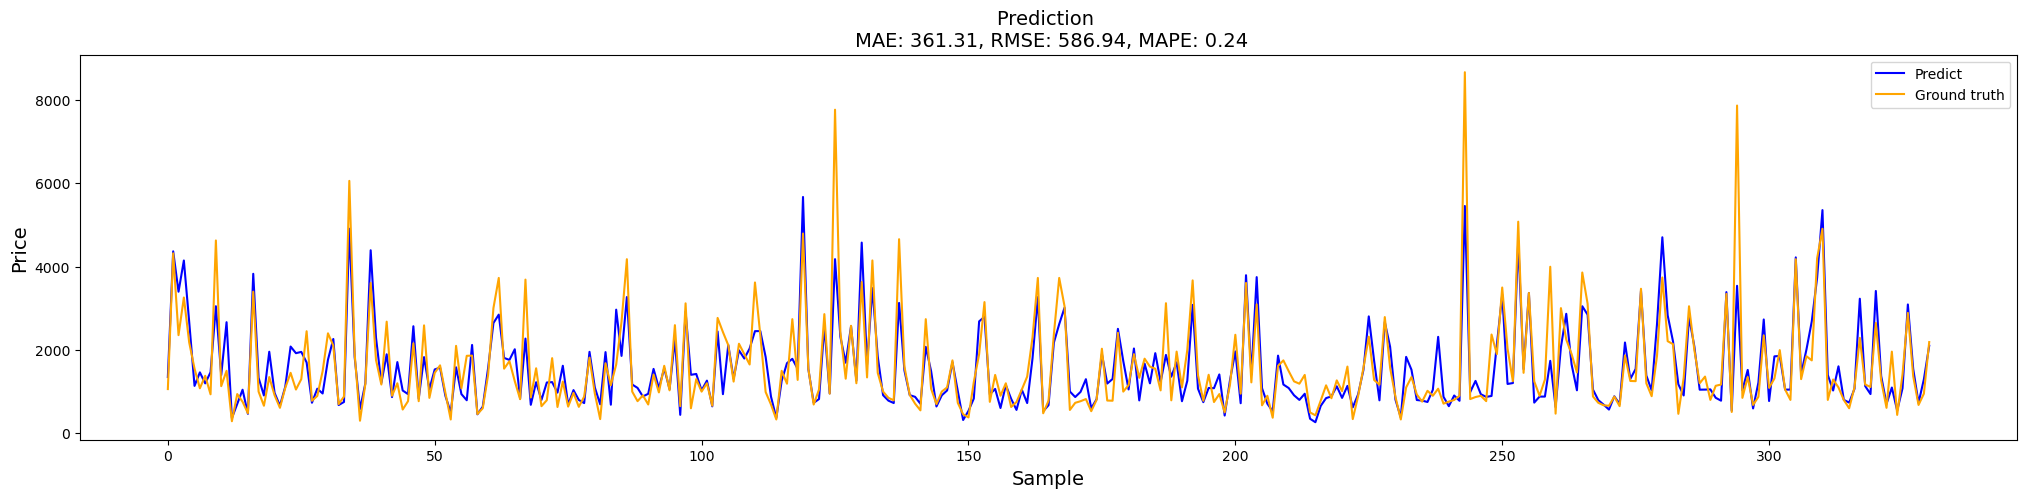

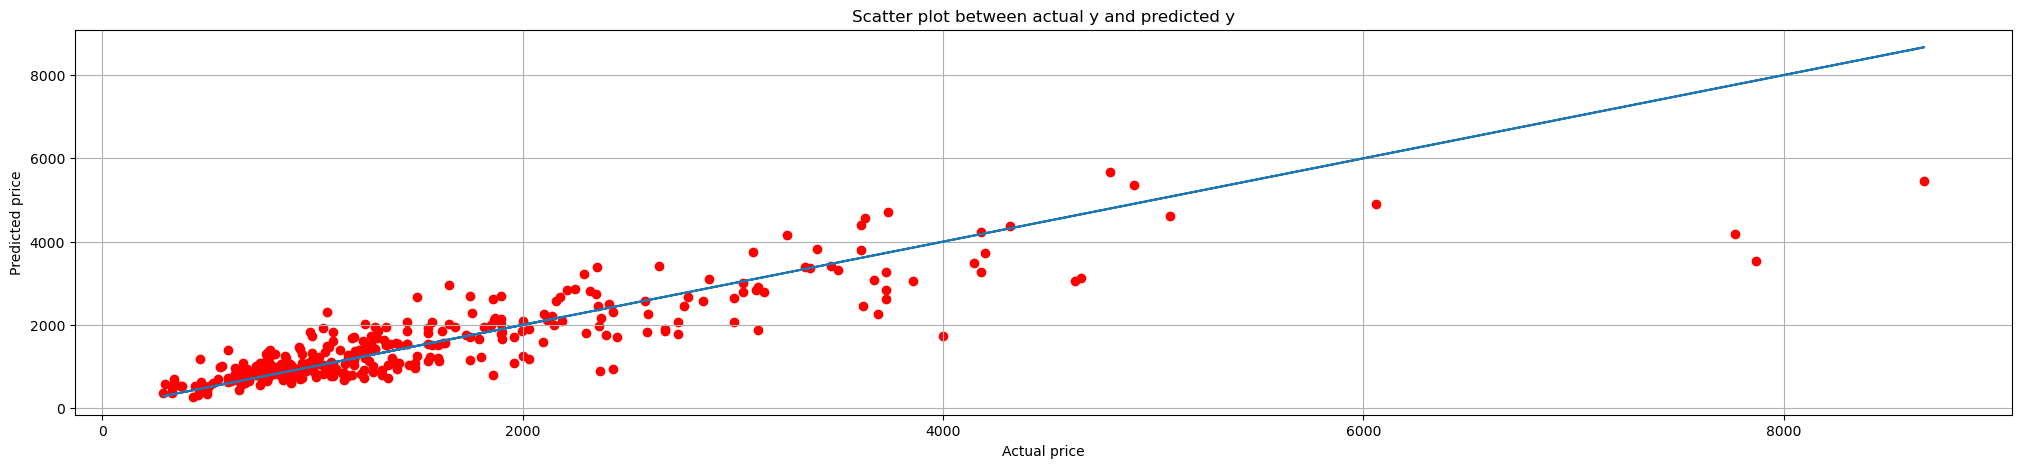

In [189]:
# Define model
linear_reg = ModelLinearRegression(preprocessing_pipeline=preprocessing)

# Train model
linear_reg.train(X_train, y_train)

# Make prediction
linear_y_pred = linear_reg.predict(X_test)

# Evaluate model
linear_score_mae, linear_score_rmse, linear_score_mape = linear_reg.evaluate(y_test, linear_y_pred)

# Visualize metrics
linear_reg.plot_result(25, 5, X_test.values, y_test)
linear_reg.plot_yy(25, 5, linear_y_pred, y_test)

## Define Support Vector Regressor model:

- Idea: Fit as many instances as possible on the street line while limiting the margin violations

In [186]:
from sklearn.svm import LinearSVR
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV
class ModelSVR:
    """
    Class Model:
    Linear Support Vector Regression's docs (using sklearn): https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html
    ---------------------
    Properties:
        model: Linear Support Vector Regression model.
        y_pred: list(float)
            Predicted values.
        score_mae: float 
            Mean absolute error score computed from y_pred and y_test (ground truth).
        score_rmse: float
            Root mean square error score computed from y_pred and y_test (ground truth).
        score_mape: float
            Mean absolute percentage error score computed from y_pred and y_test (ground truth).
    ---------------------
    Methods:
        __init__(self, preprocessing_pipeline):
            Initialize the model pipeline.
        
        train(self, X_train, y_train):
            Train the model using train dataset.
        
        predict(self, X_test):
            Predict the values using data in X_test.
        
        evaluate(self, y_true, y_pred) -> tuple(float):
            Evaluate the predict result by computing 3 metrics scores (MAE, RMSE, MAPE)
        
        plot_result(self, width, height, X_test, y_test):
            Visualize the result including predict values (blue), ground truth (yellow).
            
        plot_yy(self, width, height, x_test, y_test):
            Visualize the predicted values & ground truth.
    """
    def __init__(self, preprocessing_pipeline):
        self.preprocessing = preprocessing_pipeline
        self.model_pipeline = make_pipeline(self.preprocessing, LinearSVR())
    
    def train(self, X_train, y_train):
        # Using randomized search CV technique to find the best hyperparameter for the linear svr model 
        
        # Define the hyperparameter grid
        param_grid = {
            'linearsvr__C': uniform(0.1, 10),          # Range of values for the C parameter
            'linearsvr__epsilon': uniform(0.01, 1)    # Range of values for the epsilon parameter
        }

        rnd_search = RandomizedSearchCV(self.model_pipeline, scoring="neg_root_mean_squared_error",
                                        param_distributions=param_grid, n_iter=100, random_state=42)
        rnd_search.fit(X_train, y_train)
        print("SVR Randomize score: " + str(rnd_search.best_score_))
        print("SVR GridSearch params: ")
        print(rnd_search.best_params_)
        
        self.model_pipeline = rnd_search.best_estimator_
                
    def predict(self, X_test):
        self.y_pred = self.model_pipeline.predict(X_test)
        return self.y_pred
    
    def evaluate(self, y_true, y_pred):
        self.score_mae = mean_absolute_error(y_true, y_pred)
        self.score_rmse = math.sqrt(mean_squared_error(y_true, y_pred))
        self.score_mape = mean_absolute_percentage_error(y_true, y_pred)
        
        print('MAE: {}'.format(self.score_mae))
        print('RMSE: {}'.format(self.score_rmse))
        print('MAPE: {}'.format(self.score_mape))
        
        return self.score_mae, self.score_rmse, self.score_mape
    
    def plot_result(self, width, height, X_test, y_test):
        f, ax = plt.subplots(1)
        f.set_figheight(height)
        f.set_figwidth(width)

        sns.lineplot(x=range(0, X_test[:, 0].shape[0]), y=self.y_pred, ax=ax, color='blue', label='Predict')
        sns.lineplot(x=range(0, X_test[:, 0].shape[0]), y=y_test, ax=ax, color='orange', label='Ground truth') 

        ax.set_title(f'Prediction \n MAE: {self.score_mae:.2f}, RMSE: {self.score_rmse:.2f}, MAPE: {self.score_mape:.2f}', fontsize=14)
        ax.set_xlabel(xlabel='Sample', fontsize=14)
        ax.set_ylabel(ylabel='Price', fontsize=14)
        plt.show()

    def plot_yy(self, width, height, y_pred, y_test):
        f, ax = plt.subplots(1)
        f.set_figheight(height)
        f.set_figwidth(width)
        plt.scatter(y_test, y_pred, color='red')
        plt.plot(y_test, y_test)
        plt.grid()
        plt.xlabel('Actual price')
        plt.ylabel('Predicted price')
        plt.title('Scatter plot between actual y and predicted y')
        plt.show()

SVR Randomize score: -620.2334444416463
SVR GridSearch params: 
{'linearsvr__C': 9.956504541106007, 'linearsvr__epsilon': 0.2520552715115004}
MAE: 346.07287692013597
RMSE: 631.9597955951994
MAPE: 0.20274049212301118


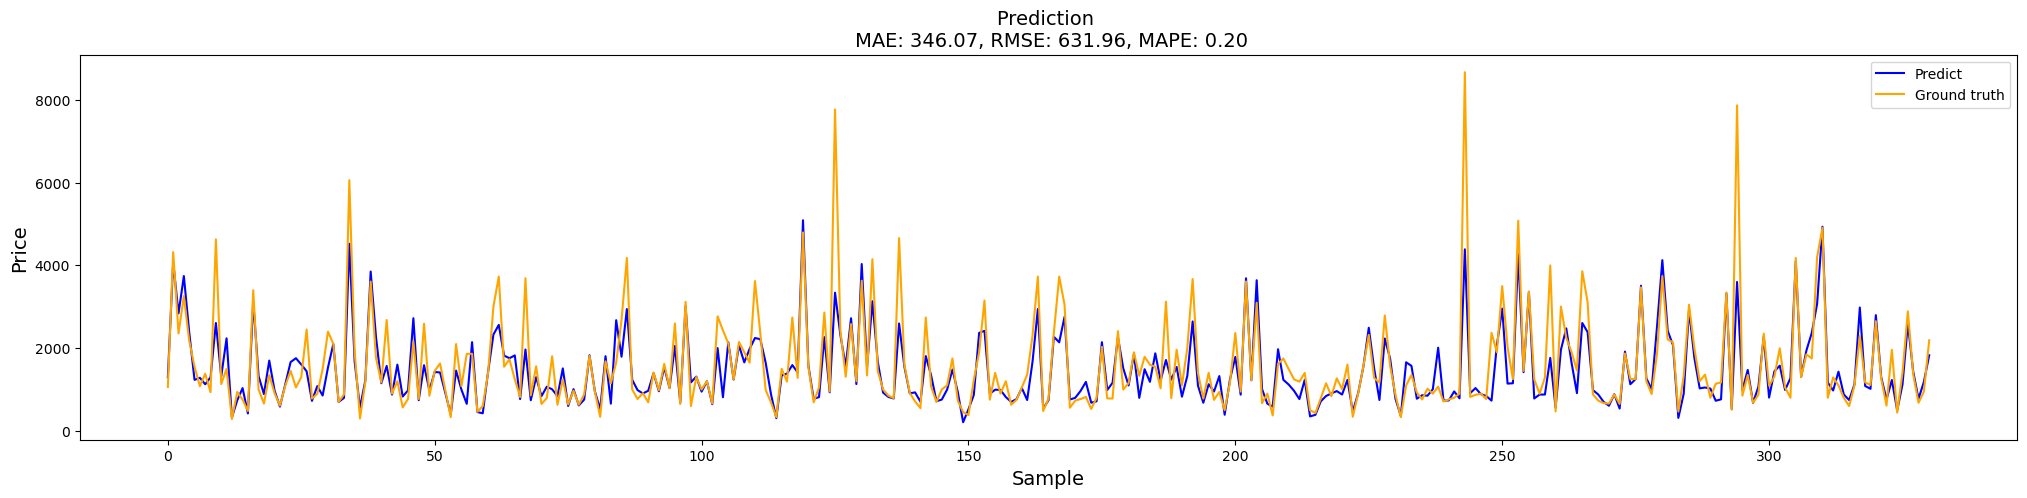

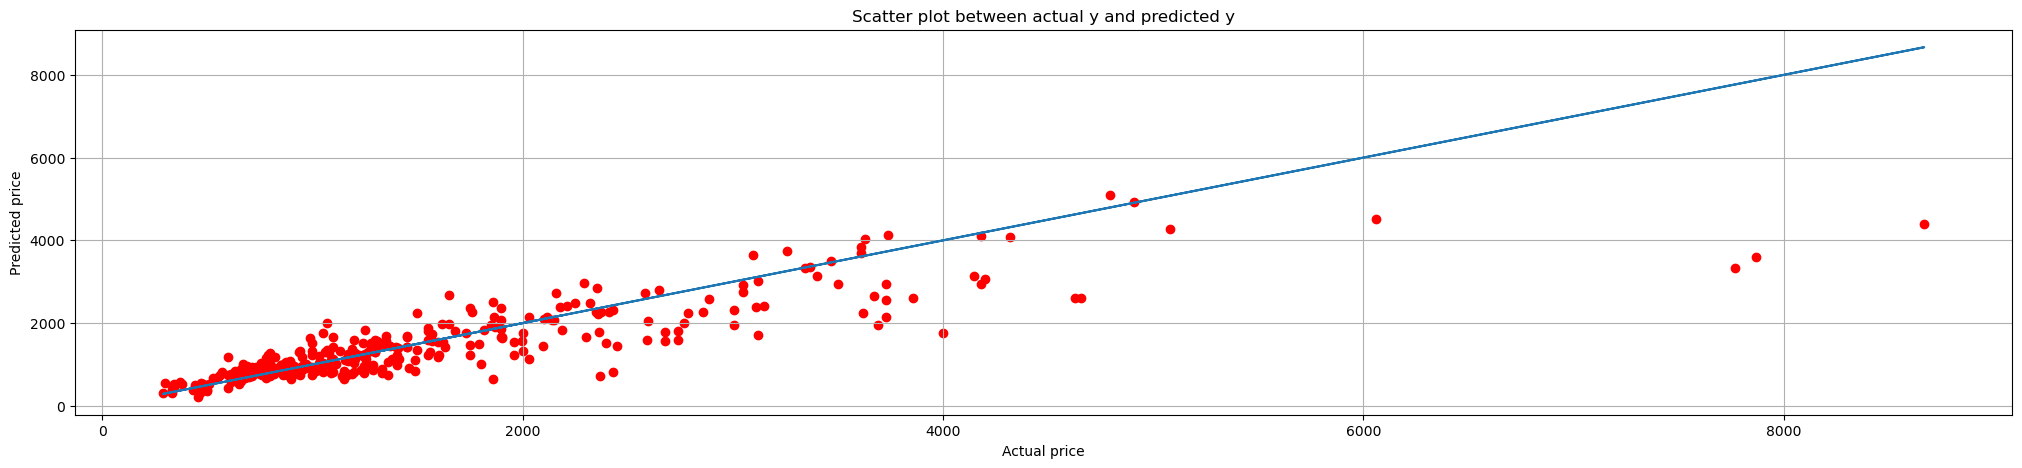

In [187]:
# Define model
svr_reg = ModelSVR(preprocessing)

# Train model
svr_reg.train(X_train, y_train)

# Make prediction
svr_y_pred = svr_reg.predict(X_test)

# Evaluate model
svr_score_mae, svr_score_rmse, svr_score_mape = svr_reg.evaluate(y_test, svr_y_pred)

# Plot results
svr_reg.plot_result(25, 5, X_test.values, y_test)
svr_reg.plot_yy(25, 5, svr_y_pred, y_test)